In [1]:
!pip install --upgrade pip
!pip install future

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple

ERROR: To modify pip, please run the following command:
C:\Users\xiandan\miniconda3\envs\d2l\python.exe -m pip install --upgrade pip



  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/47/6a/453160888fab7c6a432a6e25f8afe6256d0d9f2cbd25971021da6491d899/pip-23.3.1-py3-none-any.whl (2.1 MB)
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


# Batch Normalization
一种使深度网络更容易训练的方法是使用更复杂的优化程序，如SGD+momentum、RMSProp或Adam。另一种策略是改变网络的架构，使其更容易训练。[1]在2015年提出了批量归一化(batch normalization)。

理解批规范化的目标,重要的是第一个意识到机器学习方法在输入数据由不相关的特性和零均值和单位方差组成时往往表现得更好。在训练神经网络时，我们可以在将数据输入网络之前对其进行预处理，以显式地将其特征去相关。这将确保网络的第一层看到的数据遵循良好的分布。然而，即使我们对输入数据进行预处理，网络较深层的激活也可能不再去相关，并且不再具有零均值或单位方差，因为它们是网络中较早层的输出。更糟糕的是，在训练过程中，随着每层权重的更新，网络每层的特征分布将发生变化。

[1]的作者假设，深度神经网络内部特征分布的变化可能会使训练深度网络更加困难。为了解决这个问题，他们建议将批量数据插入到网络层中。在训练时，该层使用小批量数据来估计每个特征的均值和标准差。然后使用这些估计的均值和标准差对小批量的特征进行中心化和归一化。在训练过程中保持这些均值和标准差的运行平均值，在测试时使用这些运行平均值来中心化和归一化特征。

这种归一化策略可能会降低网络的表示能力，因为有时它可能是某些层具有非零均值或单位方差特征的最佳选择。为此，批量归一化层包括每个特征维度的可学习偏移和尺度参数。

[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

In [7]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from dlcv.classifiers.fc_net import *
from dlcv.data_utils import get_CIFAR10_data
from dlcv.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from dlcv.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def print_mean_std(x,axis=0):
    print(f"  means: {x.mean(axis=axis)}")
    print(f"  stds:  {x.std(axis=axis)}\n")

In [8]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


# Batch Normalization: Forward Pass
在文件`dlcv/layers.py`中，在函数`batchnorm_forward`中实现批量归一化正向传递。完成后，运行下面的代码来测试你的实现。

参考上面[1]中链接的论文可能会有帮助!

In [9]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization   

# Simulate the forward pass for a two-layer network.
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print_mean_std(a,axis=0)

gamma = np.ones((D3,))
beta = np.zeros((D3,))

# Means should be close to zero and stds close to one.
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])

# Now means should be close to beta and stds close to gamma.
print('After batch normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

Before batch normalization:
  means: [ -2.3814598  -13.18038246   1.91780462]
  stds:  [27.18502186 34.21455511 37.68611762]

After batch normalization (gamma=1, beta=0)
  means: [ 5.55111512e-17  3.44169138e-17 -5.27355937e-18]
  stds:  [0.99999999 1.         1.        ]

After batch normalization (gamma= [1. 2. 3.] , beta= [11. 12. 13.] )
  means: [11. 12. 13.]
  stds:  [0.99999999 1.99999999 2.99999999]



In [10]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)

for t in range(50):
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print_mean_std(a_norm,axis=0)

After batch normalization (test-time):
  means: [-0.03927354 -0.04349152 -0.10452688]
  stds:  [1.01531428 1.01238373 0.97819988]



# Batch Normalization: Backward Pass
现在在文件`dlcv/layers.py`中，在函数`batchnorm_backward`中实现批量归一化的反向传递。

为了推导反向传递，你应该写出通过每个中间节点进行批量归一化和反向传递的计算图。有些中间产物可能有多个外向分支;确保在反向传递中对这些分支的梯度求和。

完成后，运行以下代码，以数字形式检查向后传递。

In [13]:
# Gradient check batchnorm backward pass.
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
print(dx)
print(dx_num)
# You should expect to see relative errors between 1e-13 and 1e-8.
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

[[-0.00310319  0.00305468 -0.00156246  0.17251307  0.01388029]
 [ 0.01147762 -0.10800884 -0.01112564 -0.02021632 -0.02098085]
 [-0.01682492 -0.01106847 -0.00384286  0.13581055 -0.04108612]
 [ 0.00845049  0.11602263  0.01653096 -0.2881073   0.04818669]]
[[-0.00310319  0.00305468 -0.00156246  0.17251307  0.01388029]
 [ 0.01147762 -0.10800884 -0.01112564 -0.02021632 -0.02098085]
 [-0.01682492 -0.01106847 -0.00384286  0.13581055 -0.04108612]
 [ 0.00845049  0.11602263  0.01653096 -0.2881073   0.04818669]]
dx error:  1.7029275364845641e-09
dgamma error:  7.420414216247087e-13
dbeta error:  2.8795057655839487e-12


# Batch Normalization: Alternative Backward Pass
在课堂上，我们讨论了sigmoid反向传递的两种不同实现。一种策略是写出一个由简单操作和所有中间值的反向传播组成的计算图。另一种策略是计算纸面上的衍生品。例如,您可以获得一个非常简单的sigmoid函数的向后经过简化梯度在纸上。

令人惊讶的是,事实证明,你可以做一个类似的简化批处理规范化向后传递!

在正向传递中，给定一组输入  $X=\begin{bmatrix}x_1\\x_2\\...\\x_N\end{bmatrix}$,

我们首先计算均值 $\mu$ 和方差 $v$.
在 $\mu$ 和 $v$ 计算后, 我们可以计算标准差 $\sigma$  规范化数据 $Y$.
下面的方程和图表描述了计算过程 ($y_i$ 是第i个元素的向量 $Y$).

\begin{align}
& \mu=\frac{1}{N}\sum_{k=1}^N x_k  &  v=\frac{1}{N}\sum_{k=1}^N (x_k-\mu)^2 \\
& \sigma=\sqrt{v+\epsilon}         &  y_i=\frac{x_i-\mu}{\sigma}
\end{align}

<img src="https://raw.githubusercontent.com/dlcv/dlcv.github.io/master/assets/a2/batchnorm_graph.png">

在反向传播过程中，我们问题的核心是计算 $\frac{\partial L}{\partial X}$, 给定我们接收到的上游梯度, $\frac{\partial L}{\partial Y}.$ 回想一下微积分中的链式法则 $\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \cdot \frac{\partial Y}{\partial X}$.

未知/困难的部分是 $\frac{\partial Y}{\partial X}$. 我们可以通过逐步推导在的局部梯度来找到这一点
$\frac{\partial v}{\partial X}$, $\frac{\partial \mu}{\partial X}$,
$\frac{\partial \sigma}{\partial v}$, 
$\frac{\partial Y}{\partial \sigma}$, 和 $\frac{\partial Y}{\partial \mu}$,
然后使用链式法则适当地组合这些梯度(以向量的形式出现!)进行计算 $\frac{\partial Y}{\partial X}$.

如果直接推理$X$和$Y$上的梯度需要矩阵乘法，这很有挑战性，请尝试首先根据单个元素$x_i$和$y_i$推理梯度:在这种情况下，您将需要提出$\frac{\partial L}{\partial x_i}$的推导，通过依赖链式法则首先计算中间$\frac{\partial \mu}{\partial x_i}, \frac{\partial v}{\partial x_i}, \frac{\partial \sigma}{\partial x_i},$，然后组装这些部分来计算$\frac{\partial y_i}{\partial x_i}$。

你应该确保每个中间梯度的推导都尽可能简化，以便于实现。

在此之后，在文件`dlcv/layers.py`中，在函数`batchnorm_backward_alt`中实现简化的批处理规范化反向传递，并通过运行以下代码来比较这两种实现。两种实现的计算结果应该几乎相同，但另一种实现应该更快一些。

In [14]:
np.random.seed(231)
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = batchnorm_forward(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = time.time()
print('dx difference: ', rel_error(dx1, dx2))
print('dgamma difference: ', rel_error(dgamma1, dgamma2))
print('dbeta difference: ', rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

dx difference:  7.494857050222097e-13
dgamma difference:  0.0
dbeta difference:  0.0
speedup: 1.00x


# Fully Connected Networks with Batch Normalization
现在你已经有了批量规范化的工作实现，回到文件`dlcv/classifiers/fc_net.py`中的` fulllyconnectednet `。修改您的实现以添加批规范化。

具体来说，当构造函数中的`normalization`参数被设置为`"batchnorm"`时，你应该在每个ReLU非线性之前插入一个批处理规范化层。网络最后一层的输出不应该被归一化。完成后，运行以下代码来检查你的实现。

**提示:**你可能会发现定义一个类似于`dlcv/layer_utils.py`文件中的那些额外的辅助层很有用。

In [15]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

# You should expect losses between 1e-4~1e-10 for W, 
# losses between 1e-08~1e-10 for b,
# and losses between 1e-08~1e-09 for beta and gammas.
for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            normalization='batchnorm')

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  if reg == 0: print()

Running check with reg =  0
Initial loss:  0.0

Running check with reg =  3.14
Initial loss:  0.0


# Batch Normalization for Deep Networks
运行以下代码，在1000个训练样本的子集上训练一个六层网络，包括批归一化和不归一化。
注意，如果这里报错，可能是因为optim.py文件相关部分没有填写

In [29]:
np.random.seed(231)

# Try training a very deep net with batchnorm.
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)

print('Solver with batch norm:')
bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True,print_every=20)
bn_solver.train()

print('\nSolver without batch norm:')
solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

Solver with batch norm:
(Iteration 1 / 200) loss: 2.333457
(Epoch 0 / 10) train acc: 0.106000; val_acc: 0.134000
(Epoch 1 / 10) train acc: 0.312000; val_acc: 0.242000
(Iteration 21 / 200) loss: 2.058981
(Epoch 2 / 10) train acc: 0.397000; val_acc: 0.288000
(Iteration 41 / 200) loss: 1.723097
(Epoch 3 / 10) train acc: 0.433000; val_acc: 0.285000
(Iteration 61 / 200) loss: 1.590062
(Epoch 4 / 10) train acc: 0.499000; val_acc: 0.328000
(Iteration 81 / 200) loss: 1.550889
(Epoch 5 / 10) train acc: 0.549000; val_acc: 0.306000
(Iteration 101 / 200) loss: 1.346545
(Epoch 6 / 10) train acc: 0.599000; val_acc: 0.342000
(Iteration 121 / 200) loss: 1.249682
(Epoch 7 / 10) train acc: 0.649000; val_acc: 0.308000
(Iteration 141 / 200) loss: 1.157084
(Epoch 8 / 10) train acc: 0.690000; val_acc: 0.315000
(Iteration 161 / 200) loss: 0.945752
(Epoch 9 / 10) train acc: 0.720000; val_acc: 0.317000
(Iteration 181 / 200) loss: 0.876574
(Epoch 10 / 10) train acc: 0.747000; val_acc: 0.316000

Solver without b

运行以下代码以可视化上面训练的两个网络的结果。你会发现使用批处理标准化有助于网络收敛更快。

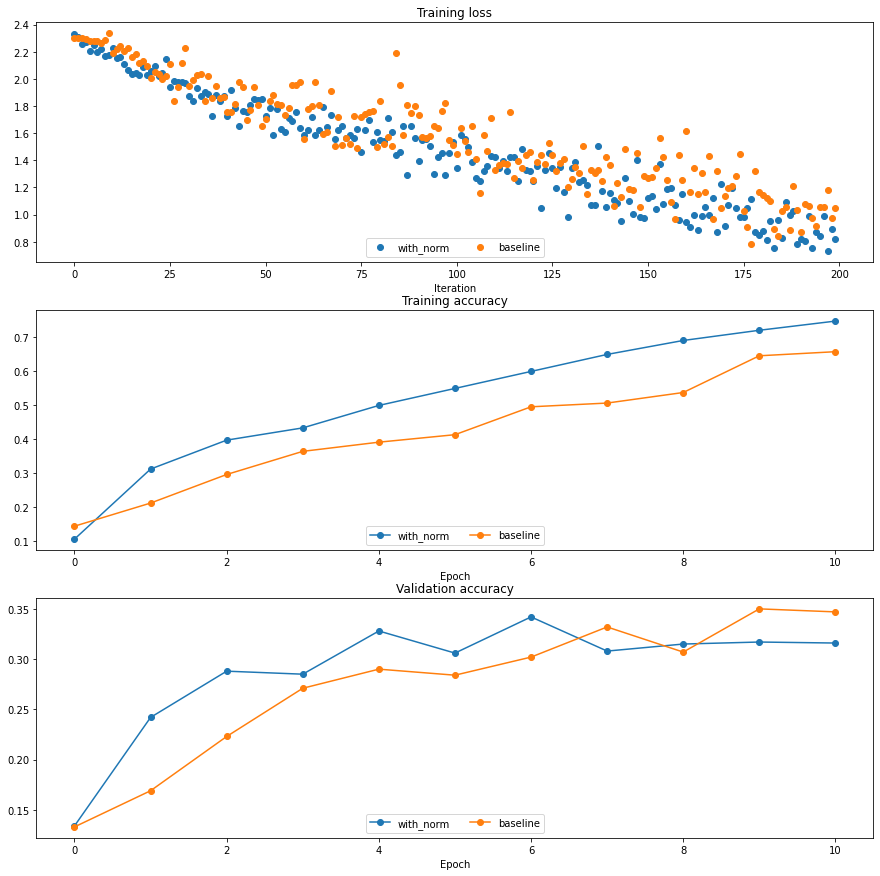

In [30]:
def plot_training_history(title, label, baseline, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plot = plot_fn(baseline)
    num_bn = len(bn_plots)
    for i in range(num_bn):
        label='with_norm'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    label='baseline'
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1) 

    
plt.subplot(3, 1, 1)
plot_training_history('Training loss','Iteration', solver, [bn_solver], \
                      lambda x: x.loss_history, bl_marker='o', bn_marker='o')
plt.subplot(3, 1, 2)
plot_training_history('Training accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history('Validation accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Batch Normalization and Initialization
我们现在将运行一个小实验来研究批化标准化和权重初始化的相互作用。第一个单元格将会对8层网络进行8层网络,没有批量标准化,使用不同的尺度来进行权重初始化。第二层将将训练精度、验证设置精度和训练损耗作为权重初始化尺度的函数。

注意，这块代码中间偶尔会出现不影响运行的警告，要求只是要完成运行20/20的结果

In [31]:
np.random.seed(231)

# Try training a very deep net with batchnorm.
hidden_dims = [50, 50, 50, 50, 50, 50, 50]
num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers_ws = {}
solvers_ws = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
    print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
    bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)

    bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
    bn_solver.train()
    bn_solvers_ws[weight_scale] = bn_solver

    solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
    solver.train()
    solvers_ws[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20


E:\作业\计算机视觉\dlcv\layers.py:884: RuntimeWarning: divide by zero encountered in log
  Inputs:


Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


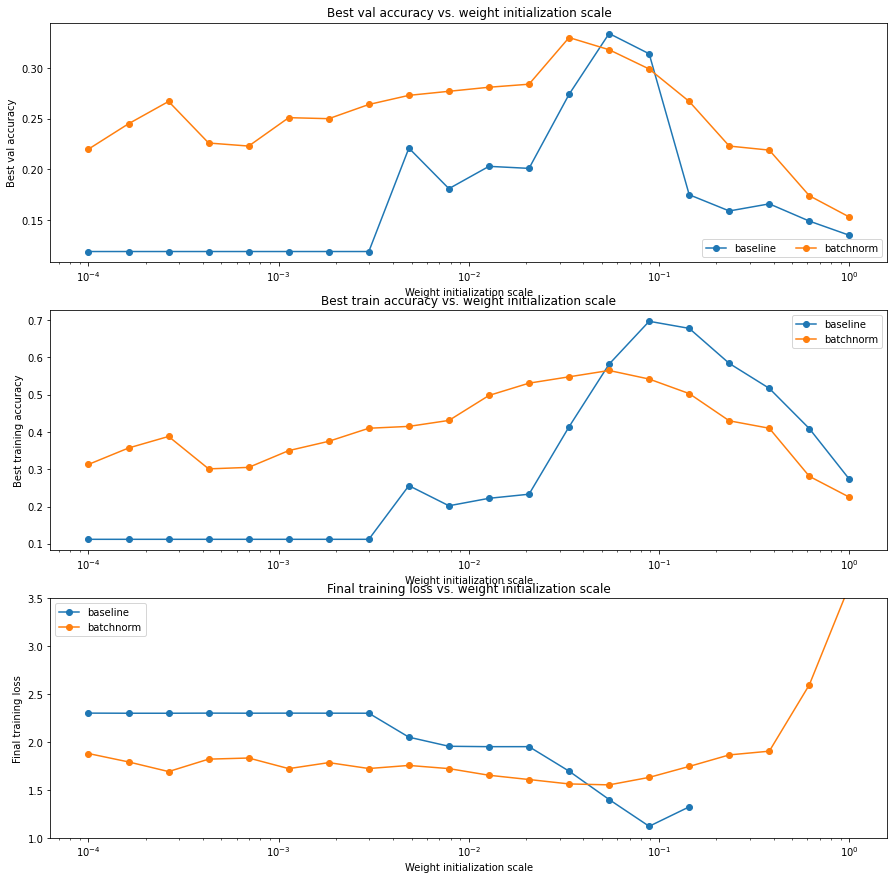

In [32]:
# Plot results of weight scale experiment.
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
  best_train_accs.append(max(solvers_ws[ws].train_acc_history))
  bn_best_train_accs.append(max(bn_solvers_ws[ws].train_acc_history))
  
  best_val_accs.append(max(solvers_ws[ws].val_acc_history))
  bn_best_val_accs.append(max(bn_solvers_ws[ws].val_acc_history))
  
  final_train_loss.append(np.mean(solvers_ws[ws].loss_history[-100:]))
  bn_final_train_loss.append(np.mean(bn_solvers_ws[ws].loss_history[-100:]))
  
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs. weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs. weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs. weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()
plt.gca().set_ylim(1.0, 3.5)

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 1:
描述实验结果。权重初始化尺度如何影响具有/不具有批量归一化的模型，为什么?

## Answer:
[权重初始化的模型再刚开始便有很好的效果，图1 展示了最好的验证集精度，图2展示了最好的训练集精度，图3展示了最终训练损失，好像存在梯度爆炸的现象]


[对于没有批量归一化的模型:在权重初始化方面，可能导致模型陷入梯度消失或爆炸的问题。权重初始化过小，可能会导致梯度消失，使得在训练过程中模型难以学习。相反，权重初始化过大，可能会导致梯度爆炸，使得模型参数迅速增大，训练不稳定甚至失效;而对于具有批量归一化的模型，它能够一定程度上缓解梯度消失或爆炸的问题。批量归一化将每个特征的值进行归一化处理，使得每层的输入分布更加稳定。这意味着在具有批量归一化的模型中，对权重初始化尺度的选择可能并不像在没有批量归一化的模型中那样敏感。一些研究表明，对于具有批量归一化的模型，权重初始化的尺度可以选择更宽范围的值而不会对模型的性能产生明显影响，因为批量归一化可以部分地解决梯度问题。]


# Batch Normalization and Batch Size
现在我们将运行一个小实验来研究批量标准化和批量大小之间的交互。

第一个单元将使用不同的批大小训练6层网络，包括使用和不使用批规范化。第二层将随着时间的推移绘制训练精度和验证集精度。

In [33]:
def run_batchsize_experiments(normalization_mode):
    np.random.seed(231)
    
    # Try training a very deep net with batchnorm.
    hidden_dims = [100, 100, 100, 100, 100]
    num_train = 1000
    small_data = {
      'X_train': data['X_train'][:num_train],
      'y_train': data['y_train'][:num_train],
      'X_val': data['X_val'],
      'y_val': data['y_val'],
    }
    n_epochs=10
    weight_scale = 2e-2
    batch_sizes = [5,10,50]
    lr = 10**(-3.5)
    solver_bsize = batch_sizes[0]

    print('No normalization: batch size = ',solver_bsize)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)
    solver = Solver(model, small_data,
                    num_epochs=n_epochs, batch_size=solver_bsize,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },
                    verbose=False)
    solver.train()
    
    bn_solvers = []
    for i in range(len(batch_sizes)):
        b_size=batch_sizes[i]
        print('Normalization: batch size = ',b_size)
        bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=normalization_mode)
        bn_solver = Solver(bn_model, small_data,
                        num_epochs=n_epochs, batch_size=b_size,
                        update_rule='adam',
                        optim_config={
                          'learning_rate': lr,
                        },
                        verbose=False)
        bn_solver.train()
        bn_solvers.append(bn_solver)
        
    return bn_solvers, solver, batch_sizes

batch_sizes = [5,10,50]
bn_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('batchnorm')

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


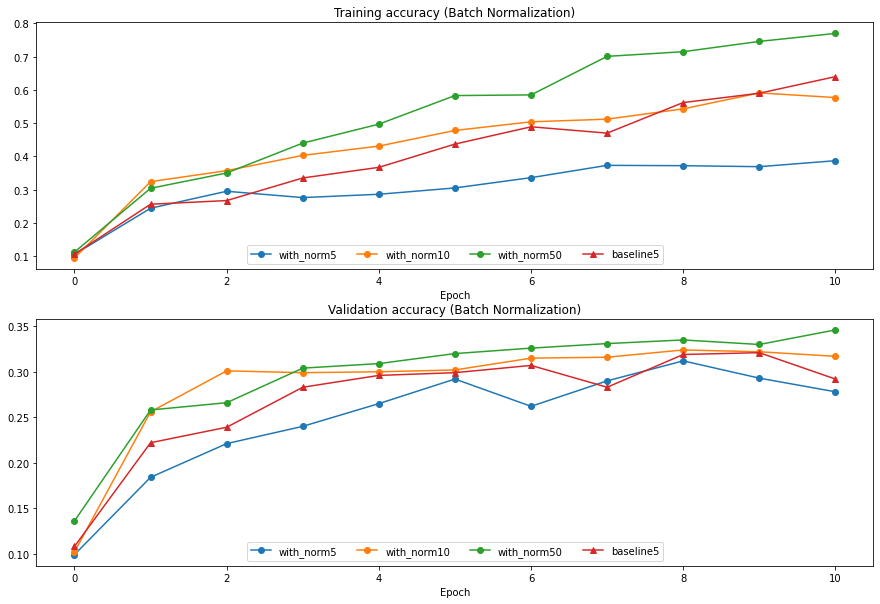

In [34]:
plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

## Inline Question 2:
描述实验结果。批规范化和批大小之间的关系意味着什么?为什么会观察到这种关系?

## Answer:
[图1展示了不同batch大小的模型训练精度，批量越大，精度约高；图2展示了不同batchsize的模型验证精度，批量越大，我们可以看到效果有点提升]

[对于没有批量归一化的模型,可能会观察到在不同批大小下，训练精度和验证集精度的收敛速度和最终性能差异较大。较小的批大小可能导致训练不稳定，难以收敛，而较大的批大小可能会有些许帮助，但性能仍可能不稳定。对于使用批量归一化的模型：可能会观察到在不同批大小下，训练精度和验证集精度的差异较小。批量归一化能够部分地抵消不同批大小对模型训练的影响，使得模型更具鲁棒性和稳定性。较大的批大小可能会降低批量归一化的效果。因为批量归一化是基于小批量数据的统计信息进行归一化处理的，当批大小增大时，可能会减弱批量归一化的效果，导致模型性能略有下降或者收敛速度变慢]

# Layer Normalization
批归一化已被证明在使网络更容易训练方面是有效的，但对批大小的依赖使其在复杂网络中用处不大，由于硬件限制，这些网络对输入批大小有上限。

几个替代批规范化提出了减轻这个问题;其中一种技术是层归一化[2]。我们对特征进行归一化，而不是对批次进行归一化。换句话说，当使用层归一化时，对应于单个数据点的每个特征向量基于该特征向量中所有项的和进行归一化。

[2] [Ba, Jimmy Lei, Jamie Ryan Kiros, and Geoffrey E. Hinton. "Layer Normalization." stat 1050 (2016): 21.](https://arxiv.org/pdf/1607.06450.pdf)

## Inline Question 3:
哪些数据预处理步骤类似于批处理规范化，哪些类似于层规范化?

1. 缩放数据集中的每个图像，使图像中每行像素的RGB通道之和为1。
2. 缩放数据集中的每个图像，使图像中所有像素的RGB通道之和为1。
3.从数据集中的每个图像中减去数据集的平均图像。
4. 根据给定的阈值将所有RGB值设置为0或1。

## Answer:
[第1和第3步骤更接近层规范化，而第2步骤更类似于批处理规范化。第4步骤则不太类似于归一化处理，而更像是二值化或阈值处理。]


# Layer Normalization: Implementation

现在你将实现层规范化。这一步应该相对简单，因为其实现在概念上几乎与批处理规范化相同。一个显著的区别是，对于层归一化，我们不跟踪移动时刻，并且测试阶段与训练阶段相同，其中直接计算每个数据点的均值和方差。

你需要这样做:

*在`dlcv/layers.py`中，在函数`layernorm_forward`中实现层规范化的正向传递。

运行下面的单元格来检查结果。
*在`dlcv/layers.py`中，在函数`layernorm_backward`中实现层规范化的反向传递。

运行下面的第二个单元格来检查您的结果。
*修改`dlcv/classifiers/fc_net.py`，为`FullyConnectedNet`添加层归一化。当在构造函数中将`normalization`标志设置为`"layernorm"`时，你应该在每个ReLU非线性之前插入一个归一化层。

运行下面的第三单元在层规范化上运行批处理大小实验。

In [36]:
# Check the training-time forward pass by checking means and variances
# of features both before and after layer normalization.

# Simulate the forward pass for a two-layer network.
np.random.seed(231)
N, D1, D2, D3 =4, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before layer normalization:')
print_mean_std(a,axis=1)

gamma = np.ones(D3)
beta = np.zeros(D3)

# Means should be close to zero and stds close to one.
print('After layer normalization (gamma=1, beta=0)')
a_norm, _ = layernorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=1)

gamma = np.asarray([3.0,3.0,3.0])
beta = np.asarray([5.0,5.0,5.0])

# Now means should be close to beta and stds close to gamma.
print('After layer normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = layernorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=1)

Before layer normalization:
  means: [-59.06673243 -47.60782686 -43.31137368 -26.40991744]
  stds:  [10.07429373 28.39478981 35.28360729  4.01831507]

After layer normalization (gamma=1, beta=0)
  means: [ 4.81096644e-16 -7.40148683e-17  2.22044605e-16 -5.92118946e-16]
  stds:  [0.99999995 0.99999999 1.         0.99999969]

After layer normalization (gamma= [3. 3. 3.] , beta= [5. 5. 5.] )
  means: [5. 5. 5. 5.]
  stds:  [2.99999985 2.99999998 2.99999999 2.99999907]



[autoreload of dlcv.classifiers.fc_net failed: Traceback (most recent call last):
  File "C:\Users\xiandan\miniconda3\envs\d2l\lib\site-packages\IPython\extensions\autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\xiandan\miniconda3\envs\d2l\lib\site-packages\IPython\extensions\autoreload.py", line 455, in superreload
    module = reload(module)
  File "C:\Users\xiandan\miniconda3\envs\d2l\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 843, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "E:\作业\计算机视觉\dlcv\classifiers\fc_net.py", line 1, in <module>
    class FullyConnectedNet(object):
  File "E:\作业\计算机视觉\dlcv\classifiers\fc_net.py", line 23, in FullyConnectedNet
    dtype=np.float32,
NameError: name 'np' is not defined
]


In [37]:
# Gradient check batchnorm backward pass.
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

ln_param = {}
fx = lambda x: layernorm_forward(x, gamma, beta, ln_param)[0]
fg = lambda a: layernorm_forward(x, a, beta, ln_param)[0]
fb = lambda b: layernorm_forward(x, gamma, b, ln_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = layernorm_forward(x, gamma, beta, ln_param)
dx, dgamma, dbeta = layernorm_backward(dout, cache)

# You should expect to see relative errors between 1e-12 and 1e-8.
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.4336182129248632e-09
dgamma error:  4.519489546032799e-12
dbeta error:  2.276445013433725e-12


# Layer Normalization and Batch Size

我们现在将运行之前的批量大小实验，使用层规范化而不是批量规范化。与之前的实验相比，你应该会看到批量大小对训练历史的影响明显变小!

In [ ]:
ln_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('layernorm')

plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Layer Normalization)','Epoch', solver_bsize, ln_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Layer Normalization)','Epoch', solver_bsize, ln_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


## Inline Question 4:
什么时候层归一化可能工作得不好，为什么?

1. 在一个非常深的网络中使用它
2. 特征维度很小的
3.具有高正则化项


## Answer:
[对于非常深的网络，层归一化可能会遇到梯度传播的问题。由于层归一化是基于每个样本内的特征进行归一化处理的，随着网络层数增加，梯度传播可能会变得更加困难，尤其是在深层网络中，梯度消失或梯度爆炸可能会影响到层归一化的有效性。
当特征维度非常小的时候，层归一化可能会失去效果。因为层归一化是在特征维度上进行归一化处理的，当特征维度很小时，对于每个特征来说，数据的统计信息可能不够丰富，这可能会导致归一化的效果不明显。当模型具有高强度的正则化项（例如L1或L2正则化）时，层归一化可能会受到负面影响。正则化项的存在可能会导致模型更加依赖于权重的大小来最小化正则化损失，这可能与层归一化的目标相冲突，从而降低其效果。]